# Measurement of Quality Factor on Cavities



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from HelpModule import *
from E5080B_driver import *
from SGS100A_driver import *
from spirack import SPI_rack, S4g_module
from IPython.display import clear_output
from time import sleep
import fitting as fit

In [2]:
twpa_on = False
vna = E5080B_driver('TCPIP0::192.168.0.235::inst0::INSTR')
vna.open()

if twpa_on:
    twpa = SGS100A_driver('TCPIP0::192.168.0.34::inst0::INSTR')
    twpa.open()

In [15]:
from datetime import datetime

params={}
params['test_date'] = datetime.today().strftime('%Y%m%d_%H%M')
params['test_type'] = 'resonatorquality'
params['qubit_name'] = 'R2401_R1'
params['twpa_on'] = twpa_on
params['vna_power'] = -55   #<-----------------------------
params['center_freq'] = 4.960e9
params['span_freq'] = 10 #In MHz
params['flux_curr'] = 0
params['temp'] = 24.4
params['comment'] = "Cavity Quality Factor Measuremnt before Annealing \n" +\
                    "# After Annealing " +\
                    "# " +\
                    "# Connection Diagram: NA" +\
                    "# \n"
npoints = 5001

if params['twpa_on']:
    twpa.set_RF(params['twpa_frequency'])
    twpa.set_level(params['twpa_power']) # dBm

Quality Factor: 45.941
3dB BW: 107928.309 kHz
f_c: 4.958 GHz


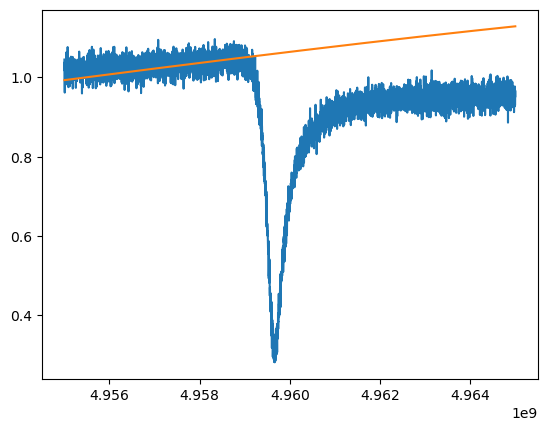

In [19]:
#First update the position of the resonance freq
meas = 'S21'
freqs, mag, phase = meas_spectrum(vna, f_c = params['center_freq'], f_span = params['span_freq'], power = params['vna_power'], 
                                  sleep_t = 25, npoints = npoints, data_format = 'MA', meas = meas)
vna.autoscale()

#f_c, Qf, fwhm = Q(freqs,mag, True)
f_c, _, fwhm = Q(freqs,max(mag)-mag, True) # Measured on trasmission 

print('Quality Factor: %2.3f'%Qf)
print('3dB BW: %2.3f kHz'%(fwhm*1e-3))
print('f_c: %2.3f GHz'%(f_c*1e-9))



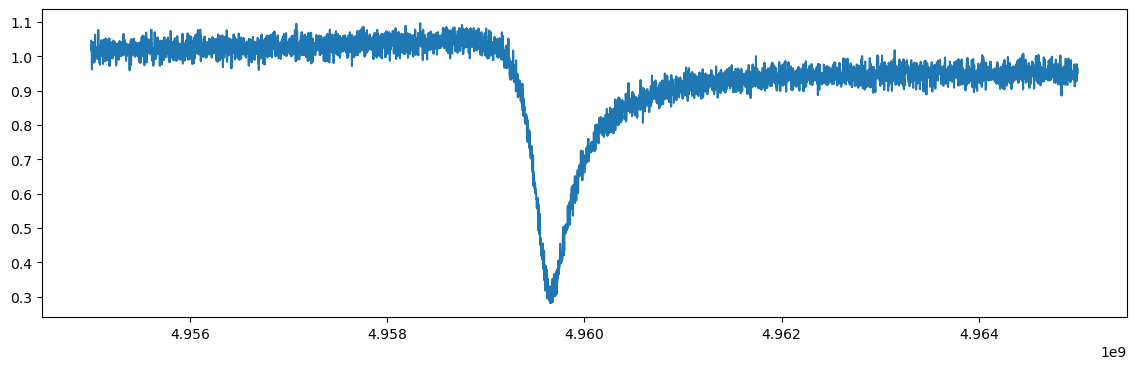

In [27]:
fig = plt.figure(figsize=(14, 4))
plt.plot(freqs, mag)
plt.show()

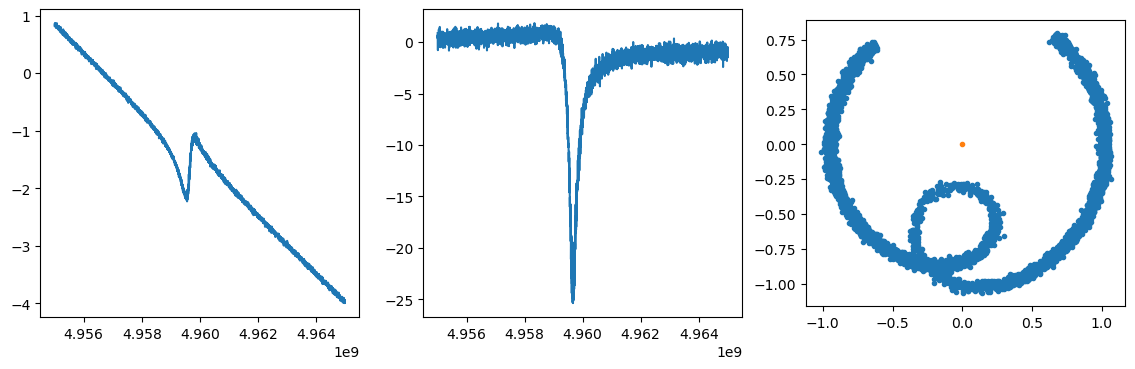

In [30]:
import matplotlib.gridspec as gridspec

angle_rad = np.unwrap(phase*np.pi/180)-np.pi*0.0
s21_complex = np.array(mag*np.exp(1j*angle_rad),dtype=np.complex128)#dtype = # 128-bit complex floating-point number

#Plot
fig = plt.figure(figsize=(14, 4))
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=0.2)
ax2 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])

ax3.plot(s21_complex.real,s21_complex.imag,'.') #add the data
ax3.plot(0,0,'.') #add the origin (0,0) point
ax3.set_aspect('equal')

ax1.plot(freqs, 20*np.log(np.abs(s21_complex)))
ax2.plot(freqs, np.unwrap(np.angle(s21_complex)))

plt.show()

$$
    S_{21}(\omega) =  A \cdot \left( 1- \frac{Q/Q_e \cdot e^{i \phi}}{1+2iQ\frac{\omega-\omega_c}{\omega_c}} \right)
    \left( 1+\alpha\frac{\omega-\omega_c}{\omega_c}   \right)
    e^{j(\phi_v \cdot \omega + \phi_0)}

$$

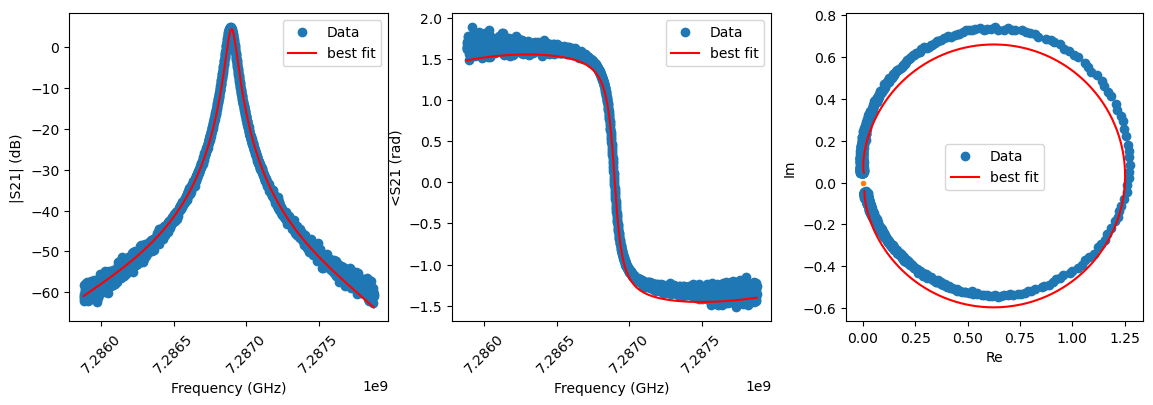


f0: 7.2869 GHz

BW: 0.0783 MHz

Q: 93107.4763

Qi: -2371.9264

Qe: 2306.3949

kc: 3.1594 MHz

theta: -0.0756

A: 0.0327

slope: -537.5694

phi_v: 0.0000

phi_0: 288.2185


Guess_parameters:

Parameters([('center', <Parameter 'center', value=7286892000.0, bounds=[-inf:inf]>), ('Q', <Parameter 'Q', value=52859.756511709485, bounds=[364.3446:7286892.0]>), ('Qe', <Parameter 'Qe', value=55254.63597437061, bounds=[1:800000.0]>), ('theta', <Parameter 'theta', value=0, bounds=[-1.5707963267948966:1.5707963267948966]>), ('A', <Parameter 'A', value=1.2368775531674, bounds=[-inf:inf]>), ('slope', <Parameter 'slope', value=-1.7368607219999873e-10, bounds=[-inf:inf]>), ('phi_v', <Parameter 'phi_v', value=0.0, bounds=[-inf:inf]>), ('phi_0', <Parameter 'phi_0', value=288.0, bounds=[-inf:inf]>), ('B', <Parameter 'B', value=0.0, bounds=[-inf:inf]>)])

Fit report:

[[Model]]
    Model(linear_resonator)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 164
    # data points   

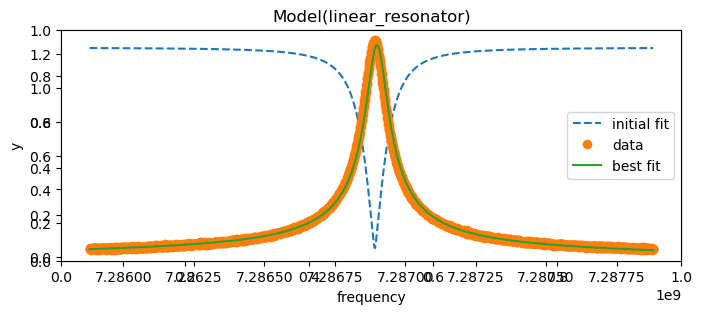

In [342]:
from importlib import reload
reload(fit)

A = max(mag)
s21_complex = np.array((mag)*np.exp(1j*angle_rad),dtype=np.complex128)#dtype = # 128-bit complex floating-point number

s21 = s21_complex*np.exp(1j*np.pi*0)
f0, BW_res, Q_res, Qi, Qe, kc, theta, a, slope, phi_v, phi_0 = fit.circle_fit_hanger(s21, freqs, plot = True, guess_BW=fwhm)

In [42]:
Qi =1./((1./Q_res) - abs(np.cos(-theta)/Qe))
print(Qi)

3184.844844755175


In [324]:
header_str = get_plot_str(params)
filename = params['test_type'] +"_"+params['qubit_name'] + "_" +params['test_date']
np.savez("./data/"+filename,
         header = header_str,
         freqs=freqs,
         mags=mag,
         phases=phase)
print('file saved as %s'%filename)

file saved as resonatorquality_CS1-03A_20231214_1711


In [ ]:
vna.autoscale()

f_c = 7286892000.000000
Q = 105719.513023
Qe = 116119.948659
phi = 0.000000
A = 1.190654
alpha = 0.000000
phi_v = 0.000000
phi_0 = 0.000000
B = 0.000000
Qi = 1180349.059827
BW_3dB = 68926.651208
kc = 0.062753


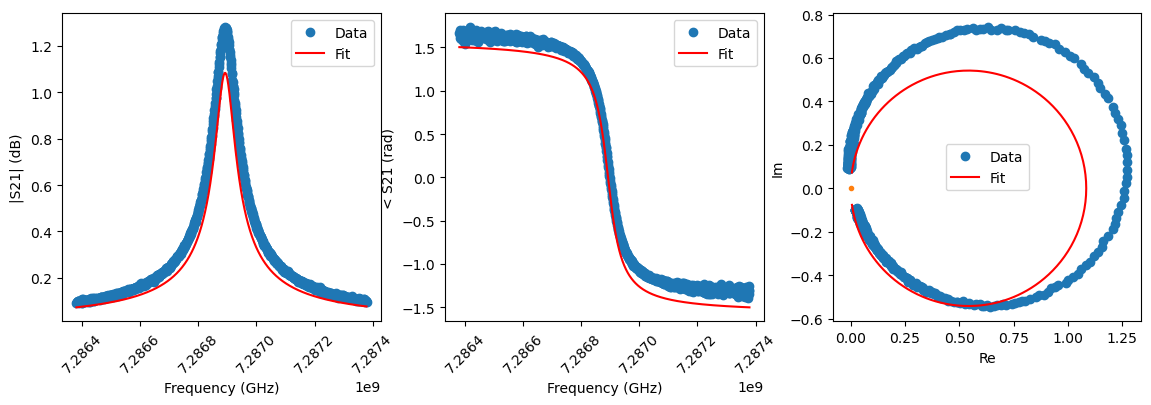

In [382]:
from importlib import reload
import qfoundry_fit
reload(qfoundry_fit)

tau =0.0e-12 #025e-12 #electrical delay in ns (first guess from VNA measure)
s21 = np.array(s21_complex*np.exp(1j*tau*freqs*2*np.pi),dtype=np.complex128)

_, results = qfoundry_fit.fit_resonance_complex(freqs[500:1500], s21[500:1500], model = "transmission", plot= True,f_c=f_c, fwhm=fwhm/2)

# to see the resukts you can call each as results['Q'] and so, or to get all of them:
for name, val in results.items():
    print(name + " = %f"%val)

In [343]:
print(A)

0.229247197509
